In [11]:
import numpy as np
from astropy.modeling.models import Box1D
import matplotlib.pyplot as plt

In [2]:
def jconvolve(h1, h2, x1, x2 = None, mode = 'math', normed = None):
    """convolve two functions with equal sample spacing
    
    mode: 'math' (default), 'average'
           math: corresonds to simply doing the convolution of two functions
           average: corresponds to averaging random variables
           sum: correspondss to sum of random variables. same as 'math'
    normed: None (default), 'density', 'max', float or int, 'none'
            if a float or in, it will scale the peak to that value
            density makes integral = 1
            max scales to peak = 1
            'none' = forces don't rescale (good for mode = math)
    
    written for dealing with PDFs, 
    
    """
    if mode=='sum':
        mode = 'math'
    
    if isinstance(normed,int):
        normed = float(normed)
    
    if x2 is None:
        x2 = x1
    
    # get sample spacing
    delta = np.diff(x1)[0]
    
    # get convolution #multiply by sample spacing (integral needs dx)
    # numpy just uses the sum, not the integral
    hconv = np.convolve(h1, h2) * delta
    
    # math mode should'nt be scaled
    # average mode should return density
    if (mode=='math') & (normed is None):
        normed = None
    elif (mode=='average') & (normed is None):
        normed = 'density'
    
    
    # the starting point is x1[0] + x2[0]
    Xconv = ((x1[0]+x2[0])/delta + np.arange(len(hconv))) * delta
    if mode=='math':
        pass
    elif mode=='average':
        #when computing the average, the x-axis is down-weighted
        # by a factor of 2. this is accomplished, by rescaling
        # the x-axis
        Xconv = Xconv / 2 #np.linspace(b[0],b[-1],len(hconv))
    
    
    # return properly scaled functions
    if (normed is None) or (normed=='none'):
        return hconv, Xconv
    
    elif normed == 'density':
        hconv /= np.sum(hconv * np.diff(Xconv)[0])
        return hconv, Xconv
    
    elif (normed == 'max') | (normed == 1):
        hconv /= np.max(hconv)
        return hconv, Xconv
    
    elif isinstance(normed,float):
        hconv /= np.max(hconv)
        hconv *= normed
        return hconv, Xconv
        


$ {\rm UnitBox[x]} = A\ \forall x \in (x_0,x_1)\ {\rm else}\ 0$

In [5]:
def convolution_of_unit_box(x,center_a,center_b,width_a,width_b,amplitudea=1,amplitudeb=1,average=False):
    if average:
        center_a,center_b,width_a,width_b, amplitudea,amplitudeb = center_a/2,center_b/2,width_a/2,width_b/2, 2*amplitudea, 2*amplitudeb
    
    c = center_a + center_b
    wc = width_a - width_b
    wc2 = width_a + width_b
#     h1 = models.Box1D(amplitude=1,x_0=center_a,width=width_a)(b)
#     h2 = models.Box1D(amplitude=1,x_0=center_b,width=width_b)(b)
    x = b
    cond1 = (c + wc/2 <  x) & (c - wc/2 > x)
    cond2 = ((wc == 0) & (c == x)) | ((wc > 0) & ((2*c + wc >= 2*x)) & (2*c <= wc + 2*x))
    cond3 = ((wc >= 0) | (2*c <= wc + 2*x)) & ((wc < 0) | (2*c + wc < 2*x)) & (2*c + wc2 > 2*x)
    cond4 = (2*c < wc2 +  2*x) & (((wc == 0) & (c > x) ) | ((2*c + wc >= 2*x) & (wc < 0)) | ((wc > 0) & (2*c > wc + 2*x)))
    funcs1 = lambda x: width_a
    funcs2 = lambda x: width_b
    funcs3 = lambda x: c + wc2/2 - x
    funcs4 = lambda x: -c + wc2/2 + x

    A = amplitudea * amplitudeb
    hc = A * np.piecewise(x,[cond1, cond2, cond3, cond4],[funcs1, funcs2, funcs3, funcs4])
    return hc

def convolution_of_unit_box_mean(x,center_a,center_b,width_a,width_b,a1,a2):
    c = center_a + center_b
    z1 = (-2 * c - width_a - width_b)/4 + x
    z2 = (-2 * c + width_a - width_b)/4 + x
    z3 = (-2 * c - width_a + width_b)/4 + x
    z4 = (-2 * c + width_a + width_b)/4 + x
    
    shape = -2 * ((-z1 * np.sign(z1)) + (z2 * np.sign(z2)) + (z3 * np.sign(z3)) - (z4 * np.sign(z4)))
    norm = width_a * width_b
    
    return   shape / norm

(-20.0, 20.0)

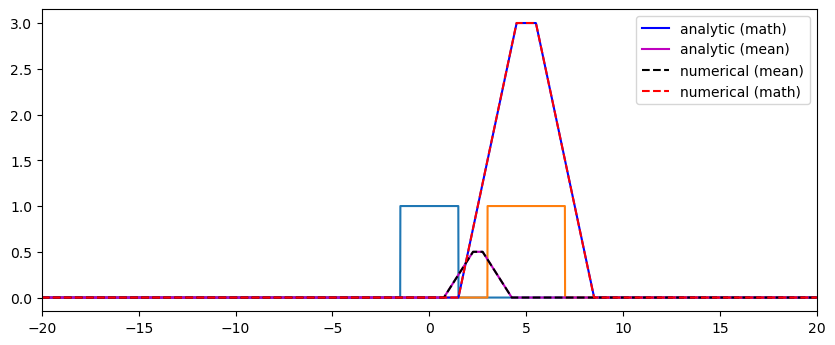

In [28]:
b = np.linspace(-50,50,10000)
delta = np.diff(b)[0]
n0 = b[0]/delta



ca,cb, wa,wb, a1,a2 = 0,5, 3,4, 1,1

    
h1 = Box1D(amplitude=a1,x_0=ca,width=wa)(b)
h2 = Box1D(amplitude=a2,x_0=cb,width=wb)(b)

hc = convolution_of_unit_box(b,ca,cb,wa,wb,a1,a2)
ha = convolution_of_unit_box_mean(b,ca,cb,wa,wb,a1,a2)

plt.figure(figsize=(10,4),dpi=100)

plt.plot(b,h1)
plt.plot(b,h2)
plt.plot(b,hc,'b-',label="analytic (math)")
plt.plot(b,ha,'m-',label="analytic (mean)")


hconv, bconv = jconvolve(h1,h2,b,mode='average')
plt.plot(bconv,hconv,'k--',label='numerical (mean)')

hconv, bconv = jconvolve(h1,h2,b,mode='math')
plt.plot(bconv,hconv,'r--',label="numerical (math)")

plt.legend()


#plt.grid('on')

plt.xlim(-20,20)

In [29]:
from scipy.integrate import trapz

In [33]:
trapz(hc,b),trapz(ha,b)

(11.999999879975997, 0.9999999899979998)